# RFM-анализ клиентов и их кластеризация

## Цель проекта
Анализ интернет-магазина с использованием RFM-анализа для сегментации клиентов
и применение алгоритмов кластеризации для выявления групп покупателей.


## 1. Импорт необходимых библиотек

Подключаем все необходимые инструменты для работы с данными, визуализации и кластеризации:
- **pandas/numpy** - обработка данных
- **matplotlib/seaborn** - визуализация
- **sklearn** - машинное обучение (кластеризация, метрики, PCA)
- **datetime** - работа с датами


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from math import pi

## 2. Загрузка данных

Загружаем датасет из Excel файла 'Online Retail.xlsx'.
Датасет содержит информацию о продажах интернет-магазина.

In [2]:
df = pd.read_excel('Online Retail.xlsx', engine='openpyxl')

## 3. Первичный анализ данных

Выполняем первичный анализ:
- Выводим информацию о структуре данных (типы данных, пропуски)
- Показываем первые 5 строк
- Выводим общую статистику

In [3]:
# Информация о датасете
print("=== Информация о датасете ===")
print(df.info())
print("\n=== Первые 5 строк ===")
print(df.head())
print("\n=== Базовая статистика ===")
print(df.describe())

=== Информация о датасете ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

=== Первые 5 строк ===
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM

## 5. Предобработка данных

Подготавливаем данные для анализа:
1. Удаляем строки с пропущенными CustomerID (необходимо для RFM-анализа)
2. Создаем столбец TotalPrice (Quantity × UnitPrice)
3. Удаляем выбросы используя IQR метод
4. Форматируем дату инвойса

In [5]:
# Удаление строк с пропущенными CustomerID
df_clean = df.dropna(subset=['CustomerID'])
print(f"Строк после удаления пропусков: {len(df_clean)}")

Строк после удаления пропусков: 406829


In [6]:
# Создание столбца TotalPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']
# Удаление отрицательных цен (возвраты) и нулевых значений
df_clean = df_clean[(df_clean['TotalPrice'] > 0) & (df_clean['Quantity'] > 0)]
print(f"Строк после удаления отрицательных значений: {len(df_clean)}")

Строк после удаления отрицательных значений: 397884


C:\Users\ArXtiM\AppData\Local\Temp\ipykernel_16000\994550931.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']


In [7]:
# Удаление выбросов методом IQR
Q1_quantity = df_clean['Quantity'].quantile(0.25)
Q3_quantity = df_clean['Quantity'].quantile(0.75)
IQR_quantity = Q3_quantity - Q1_quantity
lower_bound_q = Q1_quantity - 1.5 * IQR_quantity
upper_bound_q = Q3_quantity + 1.5 * IQR_quantity

Q1_price = df_clean['TotalPrice'].quantile(0.25)
Q3_price = df_clean['TotalPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_p = Q1_price - 1.5 * IQR_price
upper_bound_p = Q3_price + 1.5 * IQR_price

df_clean = df_clean[(df_clean['Quantity'] >= lower_bound_q) & (df_clean['Quantity'] <= upper_bound_q) &
                   (df_clean['TotalPrice'] >= lower_bound_p) & (df_clean['TotalPrice'] <= upper_bound_p)]
print(f"Строк после удаления выбросов: {len(df_clean)}")

Строк после удаления выбросов: 357941


## 6. RFM-анализ

RFM - это методология сегментации на основе трех метрик:
- **Recency (R)** - Давность последней покупки (дней назад)
- **Frequency (F)** - Частота покупок (количество транзакций)
- **Monetary (M)** - Денежная стоимость (общая сумма покупок)

Вычисляем эти метрики для каждого клиента.

In [8]:
# Преобразование даты в datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Установка базовой даты (на один день позже последней покупки)
NOW = df_clean['InvoiceDate'].max() + timedelta(days=1)

# Группировка по CustomerID и расчет RFM
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency
    'InvoiceNo': 'count',                            # Frequency
    'TotalPrice': 'sum'                              # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(f"RFM таблица создана для {len(rfm)} клиентов")
print(rfm.head())

RFM таблица создана для 4181 клиентов
   CustomerID  Recency  Frequency  Monetary
0     12347.0        2        163   3056.12
1     12348.0       75          9    210.20
2     12349.0       19         66   1145.35
3     12350.0      310         17    334.40
4     12352.0       36         80   1505.74


## 7. Визуализация RFM метрик

Строим гистограммы распределения каждой метрики и корреляционную матрицу.
Помогает понять распределение и взаимосвязь параметров.

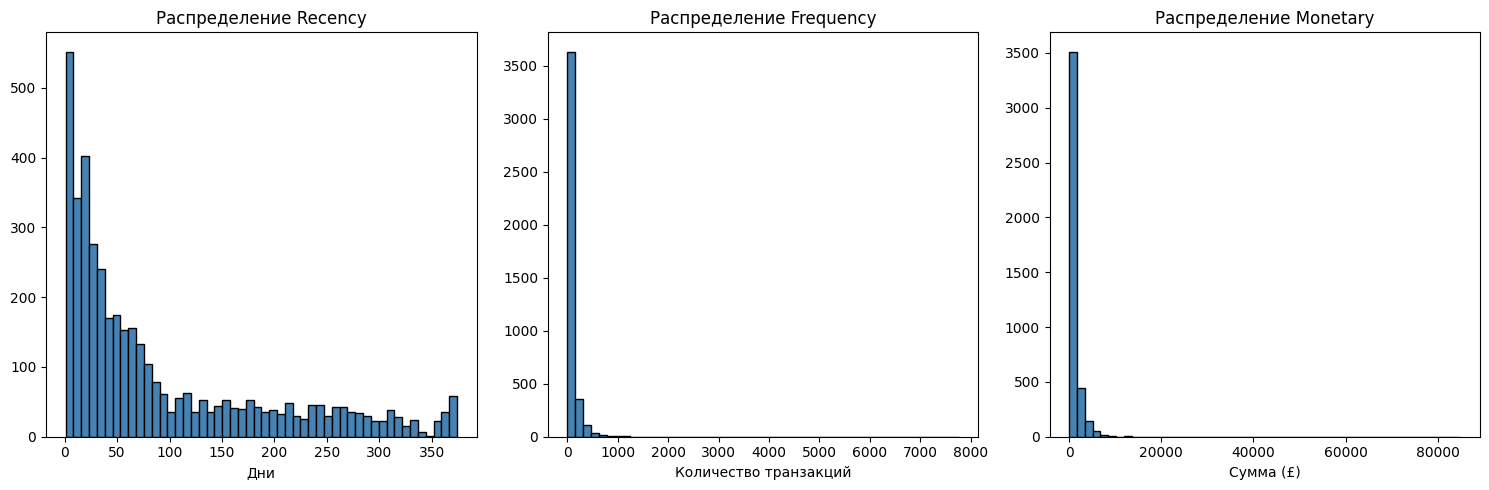

In [9]:
# Гистограммы для RFM метрик
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(rfm['Recency'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_title('Распределение Recency')
axes[0].set_xlabel('Дни')

axes[1].hist(rfm['Frequency'], bins=50, color='steelblue', edgecolor='black')
axes[1].set_title('Распределение Frequency')
axes[1].set_xlabel('Количество транзакций')

axes[2].hist(rfm['Monetary'], bins=50, color='steelblue', edgecolor='black')
axes[2].set_title('Распределение Monetary')
axes[2].set_xlabel('Сумма (£)')

plt.tight_layout()
plt.show()

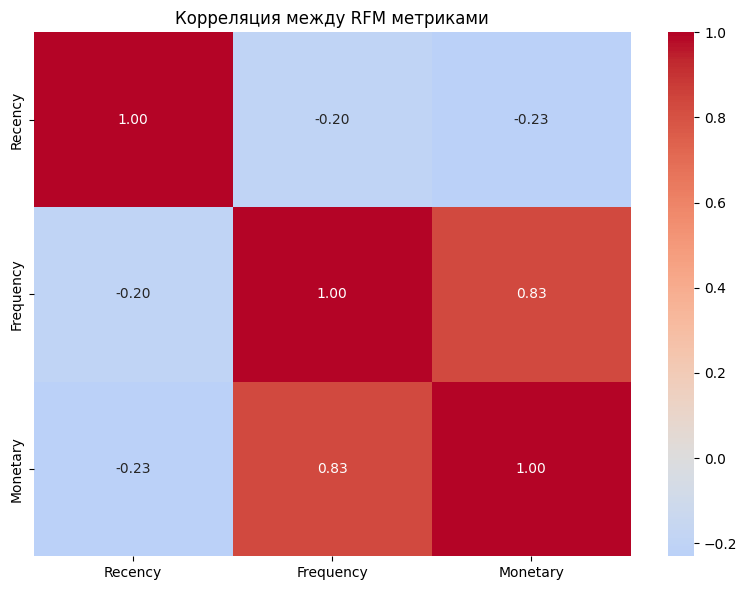

         CustomerID      Recency    Frequency      Monetary
count   4181.000000  4181.000000  4181.000000   4181.000000
mean   15296.181296    92.870844    85.611337   1006.018085
std     1718.642406    99.915584   216.880978   2120.265608
min    12347.000000     1.000000     1.000000      1.900000
25%    13816.000000    18.000000    16.000000    211.880000
50%    15296.000000    51.000000    39.000000    481.750000
75%    16775.000000   145.000000    93.000000   1136.660000
max    18287.000000   374.000000  7766.000000  84933.320000


In [10]:
# Корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), 
            annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляция между RFM метриками')
plt.tight_layout()
plt.show()

print(rfm.describe())

Корреляционная матрица показывает умеренную положительную связь между частотой покупок (Frequency) и денежной ценностью клиента (Monetary), то есть чем чаще клиент совершает заказы, тем больше он в среднем тратит средств.​

Давность последней покупки (Recency) слабо отрицательно коррелирует с Frequency и Monetary: чем меньше дней прошло с последней покупки, тем, как правило, выше частота и суммарные траты клиента.

## 8. Подготовка данных для кластеризации

Перед применением алгоритмов кластеризации необходимо:
1. Стандартизировать данные (StandardScaler) и логарифмировать их
2. Определить оптимальное количество кластеров

In [22]:
# Стандартизация данных
# Подготовка признаков
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Log-трансформация для скошенных данных
rfm_features['Recency_log'] = np.log1p(rfm_features['Recency'])
rfm_features['Frequency_log'] = np.log1p(rfm_features['Frequency'])
rfm_features['Monetary_log'] = np.log1p(rfm_features['Monetary'])

# Стандартизация
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features[['Recency_log', 'Frequency_log', 'Monetary_log']])

# Настройки для графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('viridis')

print(f"Данные стандартизированы. Форма: {rfm_scaled.shape}")

Данные стандартизированы. Форма: (4181, 3)


C:\Users\ArXtiM\AppData\Local\Temp\ipykernel_16000\3188973010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_features['Recency_log'] = np.log1p(rfm_features['Recency'])
C:\Users\ArXtiM\AppData\Local\Temp\ipykernel_16000\3188973010.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_features['Frequency_log'] = np.log1p(rfm_features['Frequency'])
C:\Users\ArXtiM\AppData\Local\Temp\ipykernel_16000\3188973010.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

## 9. Метод Локтя (Elbow Method)

Определяем оптимальное количество кластеров путем анализа инерции (сумма квадратов расстояний).
Ищем "локоть" на графике - точку, где уменьшение инерции замедляется.

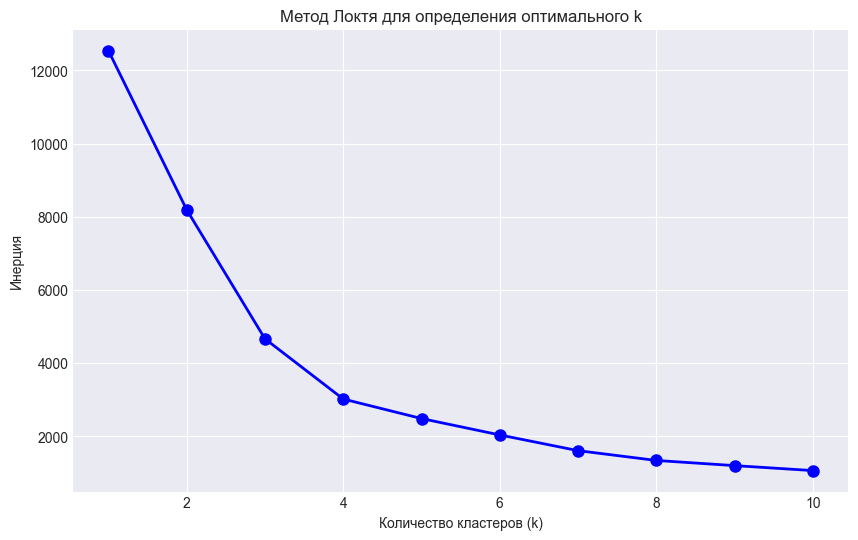

In [12]:
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Инерция')
plt.title('Метод Локтя для определения оптимального k')
plt.grid(True)
plt.show()

## 10. Метод Силуэта (Silhouette Score)

Вычисляем коэффициент силуэта для разного количества кластеров.
Более высокие значения указывают на лучшую сепарацию кластеров (диапазон: -1 до 1).

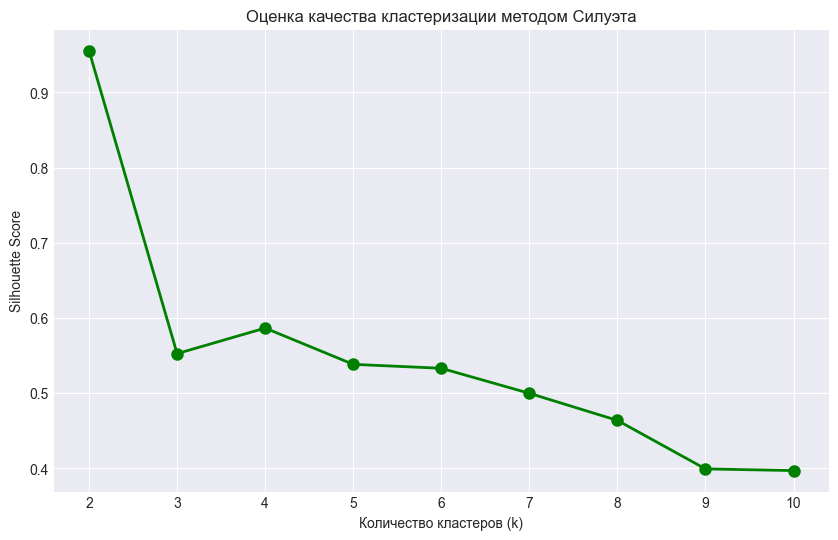

Лучшее k по Silhouette Score: 2 (значение: 0.956)


In [13]:
silhouette_scores = []

for k in k_range[1:]:  # Начинаем с k=2, так как k=1 не имеет смысла
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров (k)')
plt.ylabel('Silhouette Score')
plt.title('Оценка качества кластеризации методом Силуэта')
plt.grid(True)
plt.show()

best_k = np.argmax(silhouette_scores) + 2
print(f"Лучшее k по Silhouette Score: {best_k} (значение: {silhouette_scores[best_k-2]:.3f})")

## 11. K-means кластеризация

Применяем алгоритм K-means с оптимальным количеством кластеров.
Это один из самых популярных и быстрых алгоритмов кластеризации.

In [23]:
optimal_k = 4  # Или используйте best_k из предыдущей ячейки
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
rfm['Cluster_KMeans'] = kmeans_final.fit_predict(rfm_scaled)

print(f"K-means кластеризация завершена с k={optimal_k}")
print(f"Распределение по кластерам:")
print(rfm['Cluster_KMeans'].value_counts().sort_index())

K-means кластеризация завершена с k=4
Распределение по кластерам:
Cluster_KMeans
0    1254
1    1046
2     988
3     893
Name: count, dtype: int64


## 12. Иерархическая кластеризация

Применяем алгоритм иерархической кластеризации с методом связи 'ward'.
Позволяет строить дендрограммы и изучать иерархическую структуру данных.

In [25]:
hierarchical = AgglomerativeClustering(n_clusters=4, linkage='ward')
rfm['Cluster_Hierarchical'] = hierarchical.fit_predict(rfm_scaled)

print(f"Иерархическая кластеризация завершена")
print(f"Распределение по кластерам:")
print(rfm['Cluster_Hierarchical'].value_counts().sort_index())

Иерархическая кластеризация завершена
Распределение по кластерам:
Cluster_Hierarchical
0    1808
1    1328
2     419
3     626
Name: count, dtype: int64


## 13. DBSCAN кластеризация

Применяем алгоритм DBSCAN (density-based clustering).
Преимущество: может находить кластеры произвольной формы и выявлять выбросы.
**Примечание**: параметры eps и min_samples необходимо подбирать под конкретные данные.

In [16]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
rfm['Cluster_DBSCAN'] = dbscan.fit_predict(rfm_scaled)

print(f"DBSCAN кластеризация завершена")
print(f"Распределение по кластерам (включая выбросы с меткой -1):")
print(rfm['Cluster_DBSCAN'].value_counts().sort_index())

DBSCAN кластеризация завершена
Распределение по кластерам (включая выбросы с меткой -1):
Cluster_DBSCAN
-1      35
 0    4146
Name: count, dtype: int64


## 14. Оценка качества кластеризации

Используем метрики для сравнения качества разных алгоритмов:
- **Silhouette Score** (выше лучше, диапазон -1 до 1)
- **Davies-Bouldin Index** (ниже лучше)
- **Calinski-Harabasz Score** (выше лучше)

In [26]:
metrics = {}

for model_name, col in [('KMeans', 'Cluster_KMeans'), 
                        ('Hierarchical', 'Cluster_Hierarchical')]:
    labels = rfm[col].values
    metrics[model_name] = {
        'Silhouette': silhouette_score(rfm_scaled, labels),
        'Davies-Bouldin': davies_bouldin_score(rfm_scaled, labels),
        'Calinski-Harabasz': calinski_harabasz_score(rfm_scaled, labels)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

print("\nИнтерпретация метрик:")
print("- Silhouette: выше 0 лучше (диапазон от -1 до 1)")
print("- Davies-Bouldin: ниже лучше")
print("- Calinski-Harabasz: выше лучше")

              Silhouette  Davies-Bouldin  Calinski-Harabasz
KMeans          0.321235        0.991565        3206.333035
Hierarchical    0.231518        1.152581        2475.054614

Интерпретация метрик:
- Silhouette: выше 0 лучше (диапазон от -1 до 1)
- Davies-Bouldin: ниже лучше
- Calinski-Harabasz: выше лучше


## 15. Визуализация кластеров с помощью PCA

Применяем PCA (Principal Component Analysis) для снижения размерности.
Это позволяет визуализировать кластеры на двумерной плоскости.

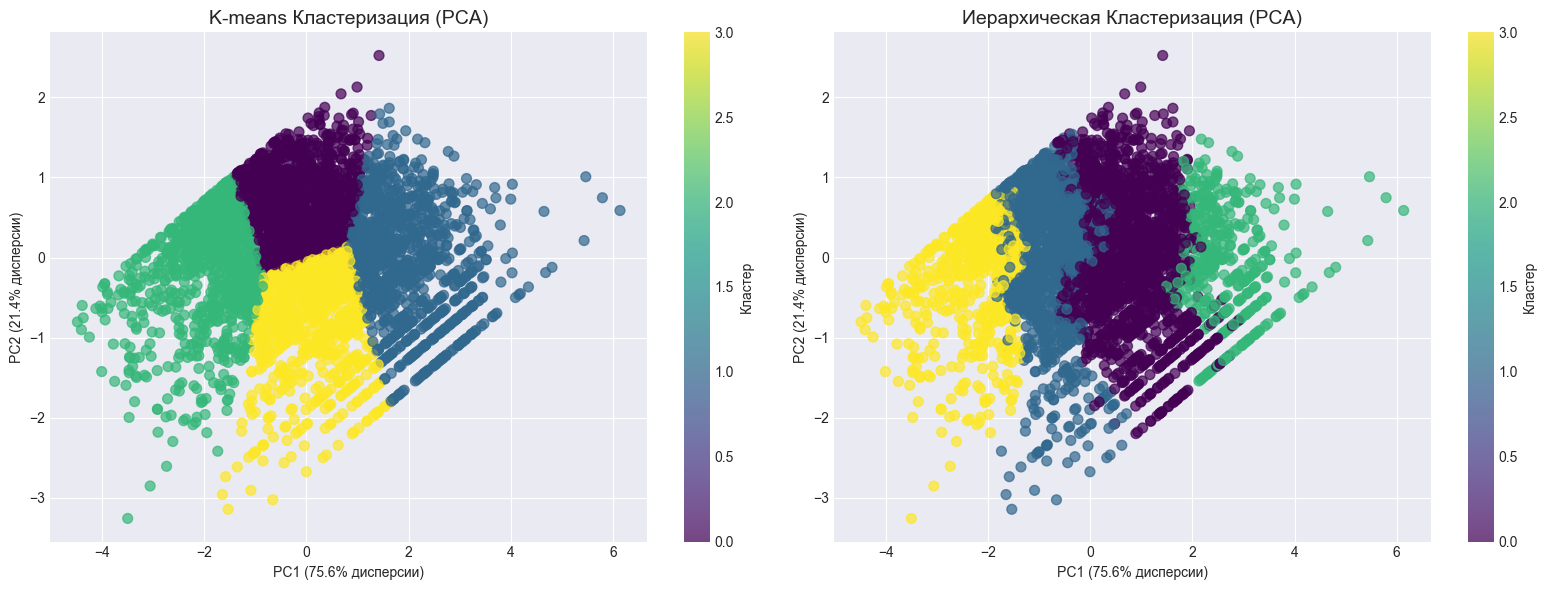

PCA объясняет 97.0% дисперсии данных


In [27]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-means визуализация
scatter1 = axes[0].scatter(rfm_pca[:, 0], rfm_pca[:, 1], 
                          c=rfm['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
axes[0].set_title('K-means Кластеризация (PCA)', fontsize=14)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.colorbar(scatter1, ax=axes[0], label='Кластер')

# Hierarchical визуализация
scatter2 = axes[1].scatter(rfm_pca[:, 0], rfm_pca[:, 1], 
                          c=rfm['Cluster_Hierarchical'], cmap='viridis', s=50, alpha=0.7)
axes[1].set_title('Иерархическая Кластеризация (PCA)', fontsize=14)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} дисперсии)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} дисперсии)')
plt.colorbar(scatter2, ax=axes[1], label='Кластер')

plt.tight_layout()
plt.show()

print(f"PCA объясняет {sum(pca.explained_variance_ratio_):.1%} дисперсии данных")

## 16. Интерпретация результатов

Анализируем характеристики каждого кластера для бизнес-интерпретации.
Выявляем различные сегменты клиентов и их поведение.

In [19]:
# Профили кластеров для K-means
print("\n=== ПРОФИЛИ КЛАСТЕРОВ (K-MEANS) ===")
print("\nСредние значения по метрикам RFM в каждом кластере:")

cluster_profiles = rfm.groupby('Cluster_KMeans')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'std', 'min', 'max'])
print(cluster_profiles)

# Размеры кластеров
print("\nРазмеры кластеров:")
print(rfm['Cluster_KMeans'].value_counts().sort_index())
print(f"\nОбщее количество клиентов: {len(rfm)}")


=== ПРОФИЛИ КЛАСТЕРОВ (K-MEANS) ===

Средние значения по метрикам RFM в каждом кластере:
                   Recency                         Frequency               \
                      mean        std  min  max         mean          std   
Cluster_KMeans                                                              
0                44.835416  36.386100    1  153    62.289182    56.838191   
1               247.771456  66.170241  143  374    26.683703    30.920253   
2                 2.000000   1.414214    1    4  5504.000000  1524.276440   
3                16.997050  21.528500    1  156   394.637168   270.196676   

                                Monetary                                    
                 min   max          mean           std       min       max  
Cluster_KMeans                                                              
0                  1   377    774.516135    669.004391      1.90   3298.78  
1                  1   288    323.506356    363.944556      2.

## 17. Классификация сегментов клиентов

На основе анализа RFM метрик каждому кластеру присваиваем бизнес-ориентированный ярлык.
Это помогает понять стратегию взаимодействия с каждым сегментом.

In [20]:
# Интерпретация сегментов
print("\n=== ИНТЕРПРЕТАЦИЯ СЕГМЕНТОВ ===")

segment_names = {
    # Условная классификация (зависит от ваших данных!)
    # Пример:
    0: 'Новые клиенты',
    1: 'Верные клиенты',
    2: 'Недавно потерянные',
    3: 'VIP клиенты'
}

rfm['Segment'] = rfm['Cluster_KMeans'].map(segment_names)

for cluster in sorted(rfm['Cluster_KMeans'].unique()):
    cluster_data = rfm[rfm['Cluster_KMeans'] == cluster]
    print(f"\n--- Кластер {cluster}: {segment_names[cluster]} ---")
    print(f"Размер: {len(cluster_data)} клиентов ({len(cluster_data)/len(rfm)*100:.1f}%)")
    print(f"Средняя давность (дни): {cluster_data['Recency'].mean():.0f}")
    print(f"Средняя частота: {cluster_data['Frequency'].mean():.1f}")
    print(f"Средняя стоимость (£): {cluster_data['Monetary'].mean():.2f}")


=== ИНТЕРПРЕТАЦИЯ СЕГМЕНТОВ ===

--- Кластер 0: Новые клиенты ---
Размер: 2801 клиентов (67.0%)
Средняя давность (дни): 45
Средняя частота: 62.3
Средняя стоимость (£): 774.52

--- Кластер 1: Верные клиенты ---
Размер: 1037 клиентов (24.8%)
Средняя давность (дни): 248
Средняя частота: 26.7
Средняя стоимость (£): 323.51

--- Кластер 2: Недавно потерянные ---
Размер: 4 клиентов (0.1%)
Средняя давность (дни): 2
Средняя частота: 5504.0
Средняя стоимость (£): 46540.56

--- Кластер 3: VIP клиенты ---
Размер: 339 клиентов (8.1%)
Средняя давность (дни): 17
Средняя частота: 394.6
Средняя стоимость (£): 4469.33


## 18. Сохранение результатов

Экспортируем результаты анализа в CSV файлы для использования в других системах.

In [21]:
# Сохранение результатов
rfm.to_csv('rfm_clustered_results.csv', index=False)
metrics_df.to_csv('clustering_metrics.csv')

print("✓ Результаты сохранены:")
print("  - rfm_clustered_results.csv")
print("  - clustering_metrics.csv")

✓ Результаты сохранены:
  - rfm_clustered_results.csv
  - clustering_metrics.csv
